# BA870 Final Project
Chuheng Yu

## Read Dataset

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
path = '/content/drive/MyDrive/BA870/'
file_names = [
    ("Compustat-1986.csv", "cp1986"), ("Compustat-2000.csv", "cp2000"),
    ("Compustat-2019.csv", "cp2019"), ("Compustat-2021.csv", "cp2021"),
    ("Compustat-2007.csv", "cp2007"), ("CRSP-1983-1987.csv", "crsp8387"),
    ("CRSP-2018-2022.csv", "crsp1822"), ("CRSP-2016-2020.csv", "crsp1620"),
    ("CRSP-1997-2001.csv", "crsp9701"), ("CRSP-2004-2008.csv", "crsp0408"),
    ("GSECTOR-2021.csv", "gs2021"),("GSECTOR-2019.csv", "gs2019"), 
    ("GSECTOR-2007.csv", "gs2007"), ("GSECTOR-2000.csv", "gs2000"), 
    ("GSECTOR-1986.csv", "gs1986"), ("FF-Output-1983-1987.csv", "ff1986"),
    ("FF-Output-1997-2001.csv", "ff2000"), ("FF-Output-2004-2008.csv", "ff2007"), 
    ("FF-Output-2016-2020.csv", "ff2019"), ("FF-Output-2018-2022.csv", "ff2021")
]

In [230]:
df_dict = {}
for x, y in file_names:
    file_path = path + x
    df_dict[y] = pd.read_csv(file_path)

#09/1987 - 12/1987

In [231]:
#use te correct dataset
crsp = df_dict['crsp8387']
crsp['date'] = pd.to_datetime(crsp['date']) 
conditioned = crsp[(crsp["date"] > '1987-08-31') & (crsp["date"] <= '1987-12-31')]
crash_return = conditioned.groupby('TICKER')['RET'].mean().reset_index()
crash_return.rename(columns={'RET': 'crash_return'}, inplace=True)
cp1 = df_dict['cp1986']
gs = df_dict['gs1986']
ff = df_dict['ff1986']

In [232]:
merged_data = pd.merge(crash_return, cp1, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, gs, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, ff, left_on='TICKER', right_on='ticker')

In [233]:
merged_data.head()

,TICKER,crash_return,gvkey_x,datadate,fyear_x,indfmt,consol,popsrc,datafmt,tic_x,...,costat,gvkey_y,fyear_y,tic_y,gsector,ticker,const,mktrf,smb,hml
0,AAL,-0.073589,1045,1986-12-31,1986,INDL,C,D,STD,AAL,...,A,1045,1986,AAL,20.0,AAL,-0.011023,0.858837,0.790875,0.416452
1,AAPL,-0.035227,1690,1986-09-30,1986,INDL,C,D,STD,AAPL,...,A,1690,1986,AAPL,45.0,AAPL,0.018018,1.332118,-0.760804,-0.846740
2,ABF,-0.100339,1213,1986-12-31,1986,INDL,C,D,STD,ABF,...,I,1213,1986,ABF,20.0,ABF,-0.001475,1.373078,1.146897,0.121233
3,ABM,-0.041749,1410,1986-10-31,1986,INDL,C,D,STD,ABM,...,A,1410,1986,ABM,20.0,ABM,-0.003411,0.739005,0.866892,-0.118238
4,ABT,-0.056657,1078,1986-12-31,1986,INDL,C,D,STD,ABT,...,A,1078,1986,ABT,35.0,ABT,0.009880,0.936448,-0.885992,-0.674876


In [234]:
merged_data.isnull().sum()

TICKER           0
crash_return     0
gvkey_x          0
datadate         0
fyear_x          0
indfmt           0
consol           0
popsrc           0
datafmt          0
tic_x            0
curcd            0
act             93
at               0
che              0
cogs             1
dltt             1
lct             74
lt               0
ni               0
re               9
sale             0
costat           0
gvkey_y          0
fyear_y          0
tic_y            0
gsector          0
ticker           0
const            0
mktrf            0
smb              0
hml              0
dtype: int64

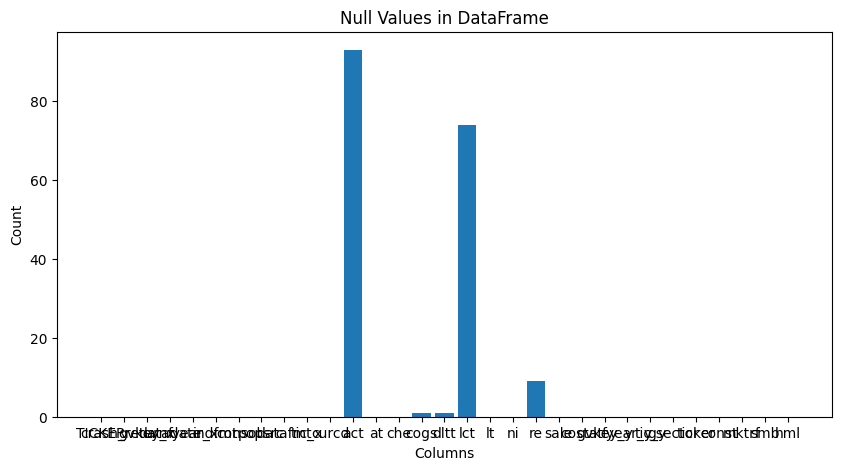

In [235]:
# Calculate the number of null values in each column
null_counts = merged_data.isnull().sum()

# Create a bar chart to visualize the null values
plt.figure(figsize=(10, 5))
plt.bar(null_counts.index, null_counts.values)
plt.title('Null Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [236]:
merged_data.drop(columns=['tic_x', 'tic_y', 'ticker'], inplace=True)

In [237]:
for_reg = pd.get_dummies(merged_data, columns=['gsector'])
for_reg.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'gsector_10.0', 'gsector_15.0',
       'gsector_20.0', 'gsector_25.0', 'gsector_30.0', 'gsector_35.0',
       'gsector_40.0', 'gsector_45.0', 'gsector_50.0', 'gsector_55.0',
       'gsector_60.0'],
      dtype='object')

In [238]:
def ols_missing(for_reg, target):
    for_reg = for_reg.drop(columns=['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
                                     'consol', 'popsrc', 'datafmt', 'curcd', 'costat', 'gvkey_y', 'fyear_y',
                                     'const', 'mktrf', 'smb', 'hml'])

    clean = for_reg.dropna(subset=[target])
    with_null = for_reg[for_reg[target].isnull()]

    col_list = clean.columns
    temp = []
    for i in col_list:
        if i not in ['act', 'cogs', 'dltt', 'lct', 're']:
            temp.append(i)

    x = clean[temp]
    y = clean[target]

    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()

    X_missing = sm.add_constant(with_null[temp], has_constant='add')

    temp = model.predict(X_missing)
    with_null.loc[:, target] = temp

    df_filled = pd.concat([clean, with_null]).sort_index()
    return df_filled


In [239]:
pd.options.mode.chained_assignment = None

#impute missing data
temp = ols_missing(for_reg, 'act')
merged_data['act'] = temp['act']
temp = ols_missing(for_reg, 'cogs')
merged_data['cogs'] = temp['cogs']
temp = ols_missing(for_reg, 'dltt')
merged_data['dltt'] = temp['dltt']
temp = ols_missing(for_reg, 'lct')
merged_data['lct'] = temp['lct']
temp = ols_missing(for_reg, 're')
merged_data['re'] = temp['re']

In [240]:
merged_data.isnull().sum()

TICKER          0
crash_return    0
gvkey_x         0
datadate        0
fyear_x         0
indfmt          0
consol          0
popsrc          0
datafmt         0
curcd           0
act             0
at              0
che             0
cogs            0
dltt            0
lct             0
lt              0
ni              0
re              0
sale            0
costat          0
gvkey_y         0
fyear_y         0
gsector         0
const           0
mktrf           0
smb             0
hml             0
dtype: int64

In [241]:
from scipy.stats.mstats import winsorize

#financial ratios
merged_data['debt_to_equity_ratio'] = (merged_data['dltt'] + (merged_data['lt'] - merged_data['lct']))/ (merged_data['at'] - merged_data['lt'])
merged_data['current_ratio'] = merged_data['act'] / merged_data['lct']
merged_data['gross_profit'] = (merged_data['sale'] - merged_data['cogs'])/ merged_data['sale']
merged_data['asset_turnover_ratio'] = merged_data['sale']/merged_data['at']
merged_data['roa'] = merged_data['ni']/merged_data['at']
merged_data['roe'] = merged_data['ni']/(merged_data['at'] - merged_data['lt'])
merged_data['net_profit_margin'] = merged_data['ni']/merged_data['sale']

#winsorize
merged_data['debt_to_equity_ratio'] = winsorize(merged_data['debt_to_equity_ratio'], limits=(0.01, 0.01))
merged_data['current_ratio'] = winsorize(merged_data['current_ratio'], limits=(0.01, 0.01))
merged_data['gross_profit'] = winsorize(merged_data['gross_profit'], limits=(0.01, 0.01))
merged_data['asset_turnover_ratio'] = winsorize(merged_data['asset_turnover_ratio'], limits=(0.01, 0.01))
merged_data['roa'] = winsorize(merged_data['roa'], limits=(0.01, 0.01))
merged_data['roe'] = winsorize(merged_data['roe'], limits=(0.01, 0.01))
merged_data['net_profit_margin'] = winsorize(merged_data['net_profit_margin'], limits=(0.01, 0.01))

In [242]:
#drop null data
merged_data = merged_data[np.isfinite(merged_data['debt_to_equity_ratio']) 
                        & np.isfinite(merged_data['current_ratio']) 
                        & np.isfinite(merged_data['gross_profit'])
                        & np.isfinite(merged_data['asset_turnover_ratio'])
                        & np.isfinite(merged_data['roa'])
                        & np.isfinite(merged_data['roe'])
                        & np.isfinite(merged_data['net_profit_margin'])]

In [243]:
merged_data = pd.get_dummies(merged_data, columns=['gsector'])
merged_data.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'debt_to_equity_ratio', 'current_ratio',
       'gross_profit', 'asset_turnover_ratio', 'roa', 'roe',
       'net_profit_margin', 'gsector_10.0', 'gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0'],
      dtype='object')

### 1. Ratio

In [245]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                  'asset_turnover_ratio','roa', 'roe', 'net_profit_margin']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.139
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000172
Time:                        03:52:00   Log-Likelihood:                 1290.2
No. Observations:                 880   AIC:                            -2564.
Df Residuals:                     872   BIC:                            -2526.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0668 

The adjusted R-squared value is 0.024 which means the model explains approximately 2.4% of the variation in crash_return after adjusting for the number of independent variables.

The only significant coefficient is debt_to_equity_ratio. The coefficient for the debt_to_equity_ratio is -0.0026. This means that for every one-unit increase in debt_to_equity_ratio, the crash_return is expected to decrease by 0.0026, holding all other factors constant. This implies that higher debt-to-equity ratios are associated with lower crash returns, suggesting that firms with higher leverage are more likely to experience lower returns during market crashes.

The coefficients for 'gross_profit', 'current_ratio', 'asset_turnover_ratio', 'roa', 'roe', and 'net_profit_margin' are not significant, with p-values greater than 0.05. This means that we cannot confidently claim that these financial ratios have a significant impact on crash_return in this model.

### 2. 3-factor risk

In [244]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     68.74
Date:                Sat, 06 May 2023   Prob (F-statistic):           6.36e-40
Time:                        03:52:00   Log-Likelihood:                 1368.9
No. Observations:                 880   AIC:                            -2730.
Df Residuals:                     876   BIC:                            -2711.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.005     -0.118      0.9

The adjusted r squared value is 0.188 indicating that 18.8% of the variation in the dependent variable can be explained by the independent variables.

The coefficient for the market risk factor (mktrf) is -0.0581. This means that for every one-unit increase in mktrf, the crash_return is expected to decrease by 0.0581, holding all other factors constant. In financial terms, this implies that higher market risk is associated with lower crash returns.

The coefficient for the size factor (smb) is -0.0120. This means that for every one-unit increase in smb, the crash_return is expected to decrease by 0.0120, holding all other factors constant. In financial terms, this implies that smaller firms (with higher smb values) are associated with lower crash returns.

The coefficient for the value factor (hml) is not significant, with a p-value of 0.516. This means that we cannot confidently claim that hml has a significant impact on crash_return in this model.

###3. Industry categorical

In [246]:
#define the independent variables
X = merged_data[['gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     6.311
Date:                Sat, 06 May 2023   Prob (F-statistic):           2.15e-09
Time:                        03:52:00   Log-Likelihood:                 1306.7
No. Observations:                 880   AIC:                            -2591.
Df Residuals:                     869   BIC:                            -2539.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0878      0.008    -11.483   

The adjusted R-squared value is 0.057. The model explains approximately 5.7% of the variation in crash_return after adjusting for the number of independent variables.

Only gsector 15, 20, 30, 35, 55, 60 and the reference industry(10) have an p value smaller than 0.05. Therefore, within this time period only these industry has a positive effect towards the crash_return which is higher than the referemce industry(10).

### 1&2

In [247]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     22.96
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.74e-38
Time:                        03:57:37   Log-Likelihood:                 1379.0
No. Observations:                 880   AIC:                            -2736.
Df Residuals:                     869   BIC:                            -2683.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0054 

The adjusted R-squared value is 0.200. The model explains approximately 20% of the variation in crash_return after adjusting for the number of independent variables.

Only mktrf and smb has a significant coefficient. The coefficient for the market risk factor (mktrf) is -0.0577. This means that for every one-unit increase in mktrf, the crash_return is expected to decrease by 0.0577, holding all other factors constant. This implies that higher market risk is associated with lower crash returns.

The coefficient for the size factor (smb) is -0.0110. This means that for every one-unit increase in smb, the crash_return is expected to decrease by 0.0110, holding all other factors constant. This implies that smaller firms (with higher smb values) are associated with lower crash returns.

The coefficients for 'debt_to_equity_ratio', 'gross_profit', 'current_ratio', 'asset_turnover_ratio', 'roa', 'roe', 'net_profit_margin', and 'hml' are not significant, with p-values greater than 0.05. This means that we cannot confidently claim that these financial ratios and the value factor (hml) have a significant impact on crash_return in this model.

### 2&3

In [248]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml','gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     19.13
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.07e-39
Time:                        04:07:24   Log-Likelihood:                 1386.9
No. Observations:                 880   AIC:                            -2746.
Df Residuals:                     866   BIC:                            -2679.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0207      0.009     -2.386   

The adjusted R-squared value is 0.211. The model explains approximately 21.1% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for the market risk factor (mktrf) is -0.0567. This means that for every one-unit increase in mktrf, the crash_return is expected to decrease by 0.0567, holding all other factors constant. This implies that higher market risk is associated with lower crash returns.

The coefficient for the size factor (smb) is -0.0112. This means that for every one-unit increase in smb, the crash_return is expected to decrease by 0.0112, holding all other factors constant. This implies that smaller firms (with higher smb values) are associated with lower crash returns.

The positive coefficients suggest that, compared to 'gsector_10.0', the industries represented by 'gsector_15.0', 'gsector_20.0', 'gsector_30.0', and 'gsector_60.0' have higher crash returns. 

 The coefficients for 'hml' and some of the 'gsector' variables are not significant, with p-values greater than 0.05. This means that we cannot confidently claim that these factors have a significant impact on crash_return in this model.

### 1&3

In [250]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.642
Date:                Sat, 06 May 2023   Prob (F-statistic):           2.96e-12
Time:                        04:14:35   Log-Likelihood:                 1322.3
No. Observations:                 880   AIC:                            -2609.
Df Residuals:                     862   BIC:                            -2522.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0947 

The adjusted R-squared value is 0.082, which is slightly lower than the R-squared value. The model explains approximately 8.2% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for the debt_to_equity_ratio is -0.0035. This means that for every one-unit increase in debt_to_equity_ratio, the crash_return is expected to decrease by 0.0035, holding all other factors constant. This implies that firms with higher debt relative to equity have lower crash returns.

The significant coefficients for the categorical industry variables indicate that there are differences in crash_return between industries. The positive coefficients suggest that, compared to the gsector_10.0, the industries represented by 'gsector_15.0', 'gsector_20.0', 'gsector_30.0', 'gsector_55.0', and 'gsector_60.0' have higher crash returns.

The coefficients for some financial ratios and some of the 'gsector' variables are not significant, with p-values greater than 0.05. This means that we cannot confidently claim that these factors have a significant impact on crash_return in this model.

### 1&2&3

In [251]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml',
                 'debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     13.39
Date:                Sat, 06 May 2023   Prob (F-statistic):           9.19e-39
Time:                        04:47:16   Log-Likelihood:                 1395.3
No. Observations:                 880   AIC:                            -2749.
Df Residuals:                     859   BIC:                            -2648.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0278 

The adjusted R-squared value is 0.220, which is slightly lower than the R-squared value. The model explains approximately 22% of the variation in crash_return after adjusting for the number of independent variables.

The constant term coefficient is -0.0278, which represents the expected crash_return value when all other independent variables are equal to zero.

The coefficient for the market risk premium is -0.0553. This means that for every one-unit increase in the market risk premium, the crash_return is expected to decrease by 0.0553, holding all other factors constant. This suggests that higher market risk premiums are associated with lower crash returns.

The coefficient for the size factor is -0.0099. This means that for every one-unit increase in the size factor, the crash_return is expected to decrease by 0.0099, holding all other factors constant. This implies that firms with smaller market capitalization have lower crash returns compared to larger firms.

The coefficient for the debt_to_equity_ratio is -0.0021. This means that for every one-unit increase in debt_to_equity_ratio, the crash_return is expected to decrease by 0.0021, holding all other factors constant. This implies that firms with higher debt relative to equity have lower crash returns.

The significant coefficients for the categorical industry variables indicate that there are differences in crash_return between industries. The positive coefficients suggest that, compared to the gsector_10.0, the industries represented by 'gsector_15.0', 'gsector_20.0', 'gsector_55.0', and 'gsector_60.0' have higher crash returns. The magnitude of the coefficients represents the difference in crash_return relative to the reference industry.

The coefficients for some financial ratios, the value factor (hml), and some of the 'gsector' variables are not significant, with p-values greater than 0.05. This means that we cannot confidently claim that these factors have a significant impact on crash_return in this model.

### Final regression

In [254]:
#define the independent variables
X = merged_data[['mktrf', 'smb',
                 'debt_to_equity_ratio',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     35.25
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.85e-43
Time:                        05:03:36   Log-Likelihood:                 1385.5
No. Observations:                 880   AIC:                            -2755.
Df Residuals:                     872   BIC:                            -2717.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0063 

The most important variables for 1987 crash is mktrf, smb, debt_to_equity_ratio, gsector_15.0, gsector_20.0 and gsector_60.0 because all of them are statiscally significance.

# 09/2000 - 03/2001

In [255]:
#use te correct dataset
crsp = df_dict['crsp9701']
crsp['date'] = pd.to_datetime(crsp['date']) 
conditioned = crsp[(crsp['date'] >= '2000-09-01') & (crsp['date'] <= '2001-03-31')]
crash_return = conditioned.groupby('TICKER')['RET'].mean().reset_index()
crash_return.rename(columns={'RET': 'crash_return'}, inplace=True)
cp1 = df_dict['cp2000']
gs = df_dict['gs2000']
ff = df_dict['ff2000']

In [256]:
merged_data = pd.merge(crash_return, cp1, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, gs, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, ff, left_on='TICKER', right_on='ticker')

In [257]:
merged_data.head()

,TICKER,crash_return,gvkey_x,datadate,fyear_x,indfmt,consol,popsrc,datafmt,tic_x,...,costat,gvkey_y,fyear_y,tic_y,gsector,ticker,const,mktrf,smb,hml
0,AABC,0.012024,16855,2000-12-31,2000,INDL,C,D,STD,AABC,...,I,16855,2000,AABC,40.0,AABC,-0.001837,0.656875,0.437663,0.871911
1,AAME,-0.007625,16671,2000-12-31,2000,INDL,C,D,STD,AAME,...,A,16671,2000,AAME,40.0,AAME,-0.011435,0.846537,0.258837,0.819471
2,AANB,0.023203,17208,2000-12-31,2000,INDL,C,D,STD,AANB,...,I,17208,2000,AANB,40.0,AANB,0.004608,0.633644,0.507936,0.666857
3,AAON,-0.023327,21542,2000-12-31,2000,INDL,C,D,STD,AAON,...,A,21542,2000,AAON,20.0,AAON,0.030781,0.977554,0.358985,0.331281
4,AAPL,-0.080819,1690,2000-09-30,2000,INDL,C,D,STD,AAPL,...,A,1690,2000,AAPL,45.0,AAPL,0.031930,0.724574,0.117040,-1.385739


In [258]:
merged_data.isnull().sum()

TICKER            0
crash_return      0
gvkey_x           0
datadate          0
fyear_x           0
indfmt            0
consol            0
popsrc            0
datafmt           0
tic_x             0
curcd             0
act             473
at                0
che               0
cogs              0
dltt              2
lct             453
lt                2
ni                0
re               25
sale              0
costat            0
gvkey_y           0
fyear_y           0
tic_y             0
gsector           1
ticker            0
const             0
mktrf             0
smb               0
hml               0
dtype: int64

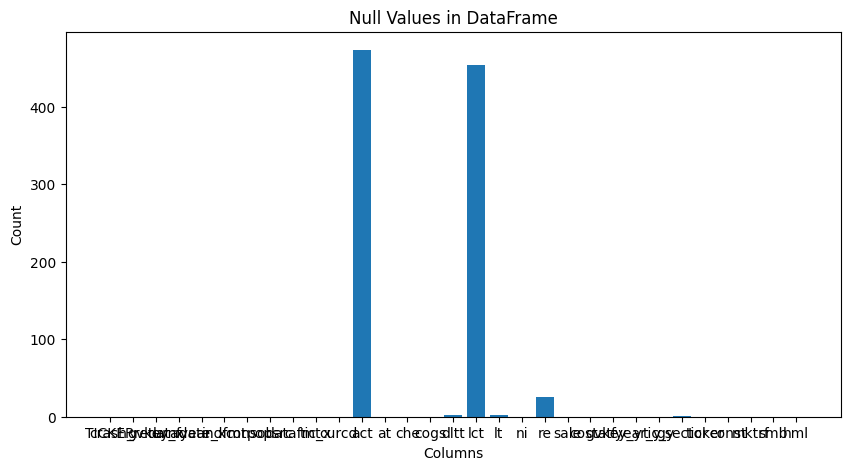

In [259]:
# Calculate the number of null values in each column
null_counts = merged_data.isnull().sum()

# Create a bar chart to visualize the null values
plt.figure(figsize=(10, 5))
plt.bar(null_counts.index, null_counts.values)
plt.title('Null Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [260]:
merged_data.drop(columns=['tic_x', 'tic_y', 'ticker'], inplace=True)

In [261]:
for_reg = pd.get_dummies(merged_data, columns=['gsector'])
for_reg.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'gsector_10.0', 'gsector_15.0',
       'gsector_20.0', 'gsector_25.0', 'gsector_30.0', 'gsector_35.0',
       'gsector_40.0', 'gsector_45.0', 'gsector_50.0', 'gsector_55.0',
       'gsector_60.0'],
      dtype='object')

In [264]:
def ols_missing(for_reg, target):
    for_reg = for_reg.drop(columns=['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
                                     'consol', 'popsrc', 'datafmt', 'curcd', 'costat', 'gvkey_y', 'fyear_y',
                                     'const', 'mktrf', 'smb', 'hml'])

    clean = for_reg.dropna(subset=[target])
    with_null = for_reg[for_reg[target].isnull()]

    col_list = clean.columns
    temp = []
    for i in col_list:
        if i not in ['act', 'lt', 'dltt', 'lct', 're']:
            temp.append(i)

    x = clean[temp]
    y = clean[target]

    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()

    X_missing = sm.add_constant(with_null[temp], has_constant='add')

    temp = model.predict(X_missing)
    with_null.loc[:, target] = temp

    df_filled = pd.concat([clean, with_null]).sort_index()
    return df_filled


In [265]:
pd.options.mode.chained_assignment = None

#impute missing data
temp = ols_missing(for_reg, 'act')
merged_data['act'] = temp['act']
temp = ols_missing(for_reg, 'cogs')
merged_data['cogs'] = temp['cogs']
temp = ols_missing(for_reg, 'dltt')
merged_data['dltt'] = temp['dltt']
temp = ols_missing(for_reg, 'lct')
merged_data['lct'] = temp['lct']
temp = ols_missing(for_reg, 're')
merged_data['re'] = temp['re']

In [267]:
from scipy.stats.mstats import winsorize

#financial ratios
merged_data['debt_to_equity_ratio'] = (merged_data['dltt'] + (merged_data['lt'] - merged_data['lct']))/ (merged_data['at'] - merged_data['lt'])
merged_data['current_ratio'] = merged_data['act'] / merged_data['lct']
merged_data['gross_profit'] = (merged_data['sale'] - merged_data['cogs'])/ merged_data['sale']
merged_data['asset_turnover_ratio'] = merged_data['sale']/merged_data['at']
merged_data['roa'] = merged_data['ni']/merged_data['at']
merged_data['roe'] = merged_data['ni']/(merged_data['at'] - merged_data['lt'])
merged_data['net_profit_margin'] = merged_data['ni']/merged_data['sale']

#winsorize
merged_data['debt_to_equity_ratio'] = winsorize(merged_data['debt_to_equity_ratio'], limits=(0.01, 0.01))
merged_data['current_ratio'] = winsorize(merged_data['current_ratio'], limits=(0.01, 0.01))
merged_data['gross_profit'] = winsorize(merged_data['gross_profit'], limits=(0.01, 0.01))
merged_data['asset_turnover_ratio'] = winsorize(merged_data['asset_turnover_ratio'], limits=(0.01, 0.01))
merged_data['roa'] = winsorize(merged_data['roa'], limits=(0.01, 0.01))
merged_data['roe'] = winsorize(merged_data['roe'], limits=(0.01, 0.01))
merged_data['net_profit_margin'] = winsorize(merged_data['net_profit_margin'], limits=(0.01, 0.01))

In [268]:
#drop null data
merged_data = merged_data[np.isfinite(merged_data['debt_to_equity_ratio']) 
                        & np.isfinite(merged_data['current_ratio']) 
                        & np.isfinite(merged_data['gross_profit'])
                        & np.isfinite(merged_data['asset_turnover_ratio'])
                        & np.isfinite(merged_data['roa'])
                        & np.isfinite(merged_data['roe'])
                        & np.isfinite(merged_data['net_profit_margin'])]

In [269]:
merged_data = pd.get_dummies(merged_data, columns=['gsector'])
merged_data.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'debt_to_equity_ratio', 'current_ratio',
       'gross_profit', 'asset_turnover_ratio', 'roa', 'roe',
       'net_profit_margin', 'gsector_10.0', 'gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0'],
      dtype='object')

### 1. Ratio

In [271]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                  'asset_turnover_ratio','roa', 'roe', 'net_profit_margin']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     36.44
Date:                Sat, 06 May 2023   Prob (F-statistic):           3.47e-48
Time:                        05:10:59   Log-Likelihood:                 2898.9
No. Observations:                1973   AIC:                            -5782.
Df Residuals:                    1965   BIC:                            -5737.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0059 

The adjusted R-squared value is 0.112, which is slightly lower than the R-squared value. The model explains approximately 11.2% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for debt_to_equity_ratio is 0.0026. This means that for every one-unit increase in debt_to_equity_ratio, the crash_return is expected to increase by 0.0026, holding all other factors constant. This implies that firms with higher debt relative to equity have higher crash returns.

The coefficient for current_ratio is -0.0029. This means that for every one-unit increase in the current_ratio, the crash_return is expected to decrease by 0.0029, holding all other factors constant. This implies that firms with higher liquidity (more current assets relative to current liabilities) have lower crash returns.

The coefficient for asset_turnover_ratio is 0.0045. This means that for every one-unit increase in asset_turnover_ratio, the crash_return is expected to increase by 0.0045, holding all other factors constant. This implies that firms with higher asset turnover (more efficient use of assets to generate revenue) have higher crash returns.

The coefficient for return on equity (roe) is 0.0226. This means that for every one-unit increase in roe, the crash_return is expected to increase by 0.0226, holding all other factors constant. This implies that firms with higher return on equity (more profitable in terms of shareholder equity) have higher crash returns.

The coefficients for 'gross_profit', 'roa', and 'net_profit_margin' are not significant, with p-values greater than 0.05. This means that we cannot confidently claim that these factors have a significant impact on crash_return in this model.

### 2. 3-factor risk

In [272]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     446.6
Date:                Sat, 06 May 2023   Prob (F-statistic):          2.71e-221
Time:                        05:11:00   Log-Likelihood:                 3290.5
No. Observations:                1973   AIC:                            -6573.
Df Residuals:                    1969   BIC:                            -6551.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.002      6.135      0.0

The adjusted R-squared value is 0.404. The model explains approximately 40.4% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for the constant term is 0.0121. This can be interpreted as the expected crash_return when all other factors in the model are equal to zero. This represents the baseline crash_return in the absence of other factors.

The coefficient for the market risk factor (mktrf) is -0.0306. This means that for every one-unit increase in mktrf, the crash_return is expected to decrease by 0.0306, holding all other factors constant. This implies that firms with higher exposure to market risk have lower crash returns.

The coefficient for the high-minus-low factor (hml) is 0.0397. This means that for every one-unit increase in hml, the crash_return is expected to increase by 0.0397, holding all other factors constant. This implies that firms with higher book-to-market values (value stocks) have higher crash returns than firms with lower book-to-market values (growth stocks).

The coefficient for 'smb' is not significant, with a p-value of 0.055, which is slightly greater than 0.05. This means that we cannot confidently claim that the small-minus-big factor has a significant impact on crash_return in this model.

###3. Industry categorical

In [273]:
#define the independent variables
X = merged_data[['gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     42.27
Date:                Sat, 06 May 2023   Prob (F-statistic):           2.95e-76
Time:                        05:11:01   Log-Likelihood:                 2971.0
No. Observations:                1973   AIC:                            -5920.
Df Residuals:                    1962   BIC:                            -5858.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0202      0.006      3.433   

The adjusted R-squared value is 0.173, which is close to the R-squared value. The model explains approximately 17.3% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for the gsector_20.0 (basic materials sector) is -0.0221. This means that, on average, companies in the basic materials sector have a crash_return that is 0.0221 lower than the baseline, holding all other factors constant. This implies that firms in the basic materials sector have lower crash returns compared to the baseline.

The coefficient for the gsector_35.0 (healthcare sector) is -0.0312. This means that, on average, companies in the healthcare sector have a crash_return that is 0.0312 lower than the baseline, holding all other factors constant. This implies that firms in the healthcare sector have lower crash returns compared to the baseline.

The coefficient for the gsector_45.0 (technology sector) is -0.0694. This means that, on average, companies in the technology sector have a crash_return that is 0.0694 lower than the baseline, holding all other factors constant. This implies that firms in the technology sector have lower crash returns compared to the baseline.

The coefficient for the gsector_50.0 (telecommunications sector) is -0.0429. This means that, on average, companies in the telecommunications sector have a crash_return that is 0.0429 lower than the baseline, holding all other factors constant. This implies that firms in the telecommunications sector have lower crash returns compared to the baseline.

The coefficients for 'gsector_15.0', 'gsector_25.0', 'gsector_30.0', 'gsector_40.0', 'gsector_55.0', and 'gsector_60.0' are not significant, meaning that we cannot confidently claim that these industry sectors have a significant impact on crash_return in this model.

### 1&2

In [274]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     139.7
Date:                Sat, 06 May 2023   Prob (F-statistic):          1.01e-220
Time:                        05:11:01   Log-Likelihood:                 3308.9
No. Observations:                1973   AIC:                            -6596.
Df Residuals:                    1962   BIC:                            -6534.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0024 

The adjusted R-squared value is 0.413. The model explains approximately 41.3% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for the debt_to_equity_ratio is 0.0007. This means that, on average, a 1-unit increase in debt_to_equity_ratio is associated with a 0.0007 increase in crash_return, holding all other factors constant. This suggests that firms with higher levels of debt relative to equity have a higher crash return.

The coefficient for gross_profit is 0.0113. This means that, on average, a 1-unit increase in gross_profit is associated with a 0.0113 increase in crash_return, holding all other factors constant. This implies that firms with higher gross profits have a higher crash return.

The coefficient for the asset_turnover_ratio is 0.0035. This means that, on average, a 1-unit increase in asset_turnover_ratio is associated with a 0.0035 increase in crash_return, holding all other factors constant. This suggests that firms with higher asset turnover ratios (i.e., more efficient use of assets) have a higher crash return.

The coefficient for return on equity (roe) is 0.0138. This means that, on average, a 1-unit increase in roe is associated with a 0.0138 increase in crash_return, holding all other factors constant. This implies that firms with higher return on equity have a higher crash return.

The coefficient for the market risk factor (mktrf) is -0.0304. This means that, on average, a 1-unit increase in mktrf is associated with a 0.0304 decrease in crash_return, holding all other factors constant. This indicates that firms with higher market risk have lower crash returns.

The coefficient for the value factor (hml) is 0.0382. This means that, on average, a 1-unit increase in hml is associated with a 0.0382 increase in crash_return, holding all other factors constant. This suggests that firms with higher value (i.e., high book-to-market ratios) have higher crash returns.

The coefficients for 'const', 'current_ratio', 'roa', 'net_profit_margin', and 'smb' are not significant, meaning that we cannot confidently claim that these factors have a significant impact on crash_return in this model.

### 2&3

In [275]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml','gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     106.9
Date:                Sat, 06 May 2023   Prob (F-statistic):          7.31e-217
Time:                        05:11:01   Log-Likelihood:                 3307.3
No. Observations:                1973   AIC:                            -6587.
Df Residuals:                    1959   BIC:                            -6508.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0200      0.005      3.773   

The adjusted R-squared value is 0.411, which is close to the R-squared value. The model explains approximately 41.1% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for the market risk factor (mktrf) is -0.0292. This means that, on average, a 1-unit increase in mktrf is associated with a 0.0292 decrease in crash_return, holding all other factors constant. This indicates that firms with higher market risk have lower crash returns.

The coefficient for the value factor (hml) is 0.0386. This means that, on average, a 1-unit increase in hml is associated with a 0.0386 increase in crash_return, holding all other factors constant. This suggests that firms with higher value (i.e., high book-to-market ratios) have higher crash returns.

The coefficient for the gsector_15.0 (Materials) is -0.0157. This means that, on average, being in the Materials sector is associated with a 0.0157 decrease in crash_return compared to the reference sector, holding all other factors constant. This implies that firms in the Materials sector have lower crash returns compared to the reference sector.

The coefficient for the gsector_20.0 (Industrials) is -0.0184. This means that, on average, being in the Industrials sector is associated with a 0.0184 decrease in crash_return compared to the reference sector, holding all other factors constant. This implies that firms in the Industrials sector have lower crash returns compared to the reference sector.

The coefficient for the gsector_45.0 (Consumer Discretionary) is -0.0138. This means that, on average, being in the Consumer Discretionary sector is associated with a 0.0138 decrease in crash_return compared to the reference sector, holding all other factors constant. IThis implies that firms in the Consumer Discretionary sector have lower crash returns compared to the reference sector.

### 1&3

In [276]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     33.46
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.06e-95
Time:                        05:11:01   Log-Likelihood:                 3030.4
No. Observations:                1973   AIC:                            -6025.
Df Residuals:                    1955   BIC:                            -5924.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0107 

The adjusted R-squared value is 0.219, which is close to the R-squared value. The model explains approximately 21.9% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for debt_to_equity_ratio is 0.0010. This means that, on average, a 1-unit increase in debt_to_equity_ratio is associated with a 0.0010 increase in crash_return, holding all other factors constant. This indicates that firms with higher debt-to-equity ratios have slightly higher crash returns.

The coefficient for gross_profit is 0.0104. This means that, on average, a 1-unit increase in gross_profit is associated with a 0.0104 increase in crash_return, holding all other factors constant. This suggests that firms with higher gross profits have higher crash returns.

The coefficient for current_ratio is -0.0021. This means that, on average, a 1-unit increase in current_ratio is associated with a 0.0021 decrease in crash_return, holding all other factors constant. This suggests that firms with higher liquidity (higher current ratios) have lower crash returns.

The coefficient for asset_turnover_ratio is 0.0068. This means that, on average, a 1-unit increase in asset_turnover_ratio is associated with a 0.0068 increase in crash_return, holding all other factors constant. This indicates that firms with higher asset turnover ratios (more efficient in using assets to generate revenue) have higher crash returns.

The coefficient for return on equity (roe) is 0.0156. This means that, on average, a 1-unit increase in roe is associated with a 0.0156 increase in crash_return, holding all other factors constant. This suggests that firms with higher return on equity have higher crash returns.

The coefficient for gsector_20.0 is -0.0221. This means that, on average, being in gsector_20.0 is associated with a 0.0221 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have lower crash returns compared to the reference industry.

The coefficient for gsector_35.0 is -0.0160. This means that, on average, being in gsector_35.0 is associated with a 0.0160 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have lower crash returns compared to the reference industry.

The coefficient for gsector_45.0 is -0.0641. This means that, on average, being in gsector_45.0 is associated with a 0.0641 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have significantly lower crash returns compared to the reference industry.

The coefficient for gsector_50.0 is -0.0424. This means that, on average, being in gsector_50.0 is associated with a 0.0424 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have significantly lower crash returns compared to the reference industry.

### 1&2&3

In [277]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml',
                 'debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     72.24
Date:                Sat, 06 May 2023   Prob (F-statistic):          1.59e-217
Time:                        05:11:01   Log-Likelihood:                 3325.0
No. Observations:                1973   AIC:                            -6608.
Df Residuals:                    1952   BIC:                            -6491.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0104 

The adjusted R-squared value is 0.419. The model explains approximately 41.9% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient for market risk factor (mktrf) is -0.0286. This means that, on average, a 1-unit increase in mktrf is associated with a 0.0286 decrease in crash_return, holding all other factors constant. This indicates that firms with higher market risk exposure have lower crash returns.

The coefficient for the high-minus-low risk factor (hml) is 0.0368. This means that, on average, a 1-unit increase in hml is associated with a 0.0368 increase in crash_return, holding all other factors constant. This suggests that firms with higher book-to-market equity ratios have higher crash returns.

The coefficient for gross_profit is 0.0116. This means that, on average, a 1-unit increase in gross_profit is associated with a 0.0116 increase in crash_return, holding all other factors constant. This suggests that firms with higher gross profits have higher crash returns.

The coefficient for asset_turnover_ratio is 0.0044. This means that, on average, a 1-unit increase in asset_turnover_ratio is associated with a 0.0044 increase in crash_return, holding all other factors constant. This indicates that firms with higher asset turnover ratios (more efficient in using assets to generate revenue) have higher crash returns.

The coefficient for return on equity (roe) is 0.0121. This means that, on average, a 1-unit increase in roe is associated with a 0.0121 increase in crash_return, holding all other factors constant. This suggests that firms with higher return on equity have higher crash returns.

The coefficient for gsector_15.0 is -0.0134. This means that, on average, being in gsector_15.0 is associated with a 0.0134 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have lower crash returns compared to the reference industry.

The coefficient for gsector_20.0 is -0.0183. This means that, on average, being in gsector_20.0 is associated with a 0.0183 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have lower crash returns compared to the reference industry.

The coefficient for gsector_45.0 is -0.0158. This means that, on average, being in gsector_45.0 is associated with a 0.0158 decrease in crash_return compared to the reference category, holding all other factors constant. This suggests that firms in this industry have lower crash returns compared to the reference industry.

### Final regression

In [279]:
#define the independent variables
X = merged_data[['mktrf', 'hml',
                 'gross_profit',
                 'asset_turnover_ratio', 'roe',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 
                 'gsector_45.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     158.9
Date:                Sat, 06 May 2023   Prob (F-statistic):          7.05e-226
Time:                        05:58:15   Log-Likelihood:                 3318.3
No. Observations:                1973   AIC:                            -6617.
Df Residuals:                    1963   BIC:                            -6561.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0090 

The most important variables for 2000 crash is mktrf, hml, gross_profit, asset_turnover_ratio , roe, gsector_15.0, gsector_20.0, gsector_25.0, and gsector_45.0 because all of them are statiscally significance.

# 02/2020 - 03/2020

In [301]:
#use te correct dataset
crsp = df_dict['crsp1620']
crsp['date'] = pd.to_datetime(crsp['date']) 
conditioned = crsp[(crsp['date'] >= '2020-02-01') & (crsp['date'] <= '2020-03-31')]
crash_return = conditioned.groupby('TICKER')['RET'].mean().reset_index()
crash_return.rename(columns={'RET': 'crash_return'}, inplace=True)
cp1 = df_dict['cp2019']
gs = df_dict['gs2019']
ff = df_dict['ff2019']

In [302]:
merged_data = pd.merge(crash_return, cp1, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, gs, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, ff, left_on='TICKER', right_on='ticker')

In [303]:
merged_data.head()

,TICKER,crash_return,gvkey_x,datadate,fyear_x,indfmt,consol,popsrc,datafmt,tic_x,...,costat,gvkey_y,fyear_y,tic_y,gsector,ticker,const,mktrf,smb,hml
0,A,-0.067438,126554,2019-10-31,2019,INDL,C,D,STD,A,...,A,126554,2019,A,35.0,A,0.003728,1.084369,-0.257950,-0.275105
1,AAL,-0.323309,1045,2019-12-31,2019,INDL,C,D,STD,AAL,...,A,1045,2019,AAL,20.0,AAL,-0.022520,1.530861,0.259539,0.796901
2,AAMC,0.113275,16720,2019-12-31,2019,INDL,C,D,STD,AAMC,...,A,16720,2019,AAMC,60.0,AAMC,0.030795,0.631664,-0.176166,0.760026
3,AAME,-0.014051,16671,2019-12-31,2019,INDL,C,D,STD,AAME,...,A,16671,2019,AAME,40.0,AAME,-0.008717,0.257933,-0.598021,0.631272
4,AAOI,-0.179895,18564,2019-12-31,2019,INDL,C,D,STD,AAOI,...,A,18564,2019,AAOI,45.0,AAOI,-0.007294,1.481282,0.947693,-0.015027


In [305]:
merged_data.isnull().sum()

TICKER            0
crash_return      0
gvkey_x           0
datadate          0
fyear_x           0
indfmt            0
consol            0
popsrc            0
datafmt           0
tic_x             0
curcd             0
act             707
at                0
che               0
cogs              0
dltt              8
lct             704
lt                7
ni                0
re               78
sale              0
costat            0
gvkey_y           0
fyear_y           0
tic_y             0
gsector           1
ticker            0
const             0
mktrf             0
smb               0
hml               0
dtype: int64

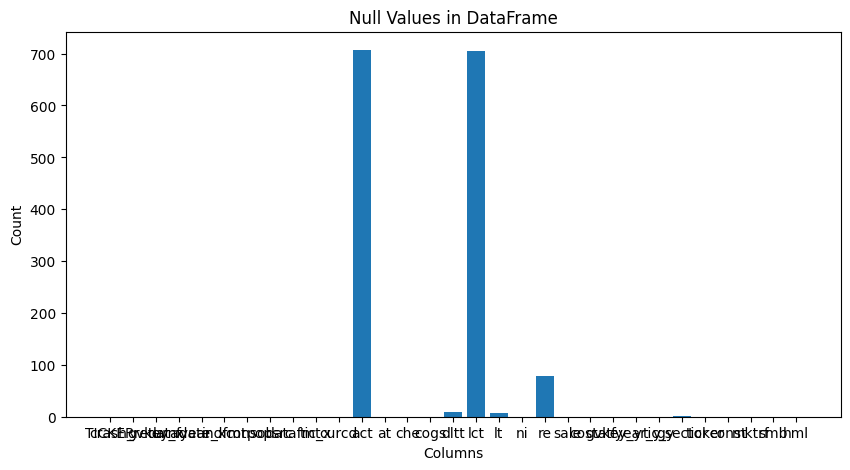

In [306]:
# Calculate the number of null values in each column
null_counts = merged_data.isnull().sum()

# Create a bar chart to visualize the null values
plt.figure(figsize=(10, 5))
plt.bar(null_counts.index, null_counts.values)
plt.title('Null Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [307]:
merged_data.drop(columns=['tic_x', 'tic_y', 'ticker'], inplace=True)

In [308]:
for_reg = pd.get_dummies(merged_data, columns=['gsector'])
for_reg.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'gsector_10.0', 'gsector_15.0',
       'gsector_20.0', 'gsector_25.0', 'gsector_30.0', 'gsector_35.0',
       'gsector_40.0', 'gsector_45.0', 'gsector_50.0', 'gsector_55.0',
       'gsector_60.0'],
      dtype='object')

In [309]:
def ols_missing(for_reg, target):
    for_reg = for_reg.drop(columns=['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
                                     'consol', 'popsrc', 'datafmt', 'curcd', 'costat', 'gvkey_y', 'fyear_y',
                                     'const', 'mktrf', 'smb', 'hml'])

    clean = for_reg.dropna(subset=[target])
    with_null = for_reg[for_reg[target].isnull()]

    col_list = clean.columns
    temp = []
    for i in col_list:
        if i not in ['act', 'lt', 'dltt', 'lct', 're']:
            temp.append(i)

    x = clean[temp]
    y = clean[target]

    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()

    X_missing = sm.add_constant(with_null[temp], has_constant='add')

    temp = model.predict(X_missing)
    with_null.loc[:, target] = temp

    df_filled = pd.concat([clean, with_null]).sort_index()
    return df_filled


In [310]:
pd.options.mode.chained_assignment = None

#impute missing data
temp = ols_missing(for_reg, 'act')
merged_data['act'] = temp['act']
temp = ols_missing(for_reg, 'cogs')
merged_data['cogs'] = temp['cogs']
temp = ols_missing(for_reg, 'dltt')
merged_data['dltt'] = temp['dltt']
temp = ols_missing(for_reg, 'lct')
merged_data['lct'] = temp['lct']
temp = ols_missing(for_reg, 're')
merged_data['re'] = temp['re']

In [311]:
from scipy.stats.mstats import winsorize

#financial ratios
merged_data['debt_to_equity_ratio'] = (merged_data['dltt'] + (merged_data['lt'] - merged_data['lct']))/ (merged_data['at'] - merged_data['lt'])
merged_data['current_ratio'] = merged_data['act'] / merged_data['lct']
merged_data['gross_profit'] = (merged_data['sale'] - merged_data['cogs'])/ merged_data['sale']
merged_data['asset_turnover_ratio'] = merged_data['sale']/merged_data['at']
merged_data['roa'] = merged_data['ni']/merged_data['at']
merged_data['roe'] = merged_data['ni']/(merged_data['at'] - merged_data['lt'])
merged_data['net_profit_margin'] = merged_data['ni']/merged_data['sale']

#winsorize
merged_data['debt_to_equity_ratio'] = winsorize(merged_data['debt_to_equity_ratio'], limits=(0.01, 0.01))
merged_data['current_ratio'] = winsorize(merged_data['current_ratio'], limits=(0.01, 0.01))
merged_data['gross_profit'] = winsorize(merged_data['gross_profit'], limits=(0.01, 0.01))
merged_data['asset_turnover_ratio'] = winsorize(merged_data['asset_turnover_ratio'], limits=(0.01, 0.01))
merged_data['roa'] = winsorize(merged_data['roa'], limits=(0.01, 0.01))
merged_data['roe'] = winsorize(merged_data['roe'], limits=(0.01, 0.01))
merged_data['net_profit_margin'] = winsorize(merged_data['net_profit_margin'], limits=(0.01, 0.01))

In [312]:
#drop null data
merged_data = merged_data[np.isfinite(merged_data['debt_to_equity_ratio']) 
                        & np.isfinite(merged_data['current_ratio']) 
                        & np.isfinite(merged_data['gross_profit'])
                        & np.isfinite(merged_data['asset_turnover_ratio'])
                        & np.isfinite(merged_data['roa'])
                        & np.isfinite(merged_data['roe'])
                        & np.isfinite(merged_data['net_profit_margin'])]

In [313]:
merged_data = pd.get_dummies(merged_data, columns=['gsector'])
merged_data.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'debt_to_equity_ratio', 'current_ratio',
       'gross_profit', 'asset_turnover_ratio', 'roa', 'roe',
       'net_profit_margin', 'gsector_10.0', 'gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0'],
      dtype='object')

### 1. Ratio

In [314]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                  'asset_turnover_ratio','roa', 'roe', 'net_profit_margin']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     11.47
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.90e-14
Time:                        06:33:15   Log-Likelihood:                 1484.3
No. Observations:                2961   AIC:                            -2953.
Df Residuals:                    2953   BIC:                            -2905.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1807 

The adjusted R-squared value is 0.024, which is slightly lower than the R-squared value. The model explains approximately 2.4% of the variation in crash_return after adjusting for the number of independent variables.

The constant term is -0.1807, which means that when all other independent variables are zero, the average crash_return will be -0.1807.

The coefficient is 0.0095, which means that for every 1-unit increase in the current ratio (current assets divided by current liabilities), the crash_return is expected to increase by 0.0095 units, holding all other variables constant.

 The coefficient is -0.0073, indicating that for every 1-unit increase in return on equity (roe), the crash_return is expected to decrease by 0.0073 units, holding all other variables constant.

### 2. 3-factor risk

In [315]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     1165.
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        06:33:16   Log-Likelihood:                 2599.8
No. Observations:                2961   AIC:                            -5192.
Df Residuals:                    2957   BIC:                            -5168.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.004      0.318      0.7

The adjusted R-squared value is 0.541, which indicates that 54.1% of the variance in the crash_return can be explained by the independent variables in this model. This is relatively high, which means the model fits the data well.

The coefficient is -0.1252, which means that for every 1-unit increase in the market return minus the risk-free rate (mktrf), the crash_return is expected to decrease by 0.1252 units, holding all other variables constant. This indicates that an increase in market returns relative to the risk-free rate results in a decrease in the crash_return, suggesting that the market return has a negative relationship with the crash_return.

The coefficient is -0.0059, which means that for every 1-unit increase in the size factor (smb), the crash_return is expected to decrease by 0.0059 units, holding all other variables constant. This suggests that smaller companies (with higher smb values) tend to have lower crash returns.

The coefficient is -0.0852, which means that for every 1-unit increase in the book-to-market ratio (hml), the crash_return is expected to decrease by 0.0852 units, holding all other variables constant. This suggests that companies with higher book-to-market ratios (value stocks) tend to have lower crash returns.

###3. Industry categorical

In [316]:
#define the independent variables
X = merged_data[['gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     39.00
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.07e-72
Time:                        06:33:16   Log-Likelihood:                 1628.5
No. Observations:                2961   AIC:                            -3235.
Df Residuals:                    2950   BIC:                            -3169.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2700      0.010    -27.029   

The adjusted R-squared value is 0.114, which is close to the R-squared value. The model explains approximately 11.4% of the variation in crash_return after adjusting for the number of independent variables.

The constant coefficient is -0.2700, which represents the baseline crash_return when all gsector dummy variables are 0 (reference category).

These coefficients represent the difference in crash_return for each industry sector compared to the reference category. For example, the coefficient for gsector_15.0 is 0.1018, which means that, holding all other variables constant, the crash_return for this sector is expected to be 0.1018 units higher than the reference category. Similar interpretations apply to the other gsector coefficients.

### 1&2

In [317]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     366.4
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        06:33:16   Log-Likelihood:                 2640.0
No. Observations:                2961   AIC:                            -5258.
Df Residuals:                    2950   BIC:                            -5192.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0066 

The adjusted R-squared value is 0.552. The model explains approximately 52.2% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient of 0.0009 suggests that for every one-unit increase in the debt_to_equity_ratio, crash_return is expected to increase by 0.0009 units, holding all other variables constant.

The coefficient of 0.0026 indicates that for every one-unit increase in the current_ratio, crash_return is expected to increase by 0.0026 units, holding all other variables constant.

The coefficient of 0.0121 implies that for every one-unit increase in the asset_turnover_ratio, crash_return is expected to increase by 0.0121 units, holding all other variables constant.

The coefficient of -0.0579 suggests that for every one-unit increase in the return on assets (ROA), crash_return is expected to decrease by 0.0579 units, holding all other variables constant.

The coefficient of -0.0092 indicates that for every one-unit increase in the return on equity (ROE), crash_return is expected to decrease by 0.0092 units, holding all other variables constant.

The coefficient of -0.1301 implies that for every one-unit increase in the market return (MktRF), crash_return is expected to decrease by 0.1301 units, holding all other variables constant.

The coefficient of -0.0108 suggests that for every one-unit increase in the size factor (SMB), crash_return is expected to decrease by 0.0108 units, holding all other variables constant.

The coefficient of -0.0794 indicates that for every one-unit increase in the value factor (HML), crash_return is expected to decrease by 0.0794 units, holding all other variables constant.


### 2&3

In [318]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml','gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     283.5
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        06:33:16   Log-Likelihood:                 2645.6
No. Observations:                2961   AIC:                            -5263.
Df Residuals:                    2947   BIC:                            -5179.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0152      0.009      1.678   

The adjusted R-squared value is 0.554, which is close to the R-squared value. The model explains approximately 55.4% of the variation in crash_return after adjusting for the number of independent variables.

The coefficient of -0.1294 suggests that for every one-unit increase in the market return (MktRF), crash_return is expected to decrease by 0.1294 units, holding all other variables constant.

The coefficient of -0.0086 indicates that for every one-unit increase in the size factor (SMB), crash_return is expected to decrease by 0.0086 units, holding all other variables constant.

The coefficient of -0.0773 implies that for every one-unit increase in the value factor (HML), crash_return is expected to decrease by 0.0773 units, holding all other variables constant.

The coefficient of -0.0265 suggests that being in industry sector 25 leads to a decrease in crash_return by 0.0265 units compared to the reference industry sector, holding all other variables constant.

The coefficient of 0.0203 indicates that being in industry sector 35 leads to an increase in crash_return by 0.0203 units compared to the reference industry sector, holding all other variables constant.

The coefficient of -0.0252 implies that being in industry sector 40 leads to a decrease in crash_return by 0.0252 units compared to the reference industry sector, holding all other variables constant.

The coefficient of -0.0442 suggests that being in industry sector 55 leads to a decrease in crash_return by 0.0442 units compared to the reference industry sector, holding all other variables constant.

The coefficient of -0.0483 indicates that being in industry sector 60 leads to a decrease in crash_return by 0.0483 units compared to the reference industry sector, holding all other variables constant.

### 1&3

In [319]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     25.18
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.36e-74
Time:                        06:33:16   Log-Likelihood:                 1645.7
No. Observations:                2961   AIC:                            -3255.
Df Residuals:                    2943   BIC:                            -3147.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2861 

The adjusted R-squared value is 0.122, which is close to the R-squared value. The model explains approximately 12.2% of the variation in crash_return after adjusting for the number of independent variables.

The constant term, or the intercept, is -0.2861. This represents the predicted crash_return when all other variables are equal to zero.

The coefficient of 0.0055 indicates that for every one-unit increase in the current ratio, crash_return is expected to increase by 0.0055 units, holding all other variables constant.

The coefficient of 0.0110 implies that for every one-unit increase in the asset turnover ratio, crash_return is expected to increase by 0.0110 units, holding all other variables constant.

The coefficient of 0.0357 suggests that for every one-unit increase in the return on assets (ROA), crash_return is expected to increase by 0.0357 units, holding all other variables constant.

The coefficient of -0.0069 indicates that for every one-unit increase in the return on equity (ROE), crash_return is expected to decrease by 0.0069 units, holding all other variables constant.

These coefficients represent the difference in crash_return between the reference industry sector and each respective industry sector. For example, being in industry sector 15 leads to an increase in crash_return by 0.0969 units compared to the reference industry sector, holding all other variables constant.

### 1&2&3

In [320]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml',
                 'debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     189.4
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        06:33:16   Log-Likelihood:                 2670.4
No. Observations:                2961   AIC:                            -5299.
Df Residuals:                    2940   BIC:                            -5173.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0140 

The adjusted R-squared value is 0.56. The model explains approximately 56.0% of the variation in crash_return after adjusting for the number of independent variables.

mktrf: The coefficient of -0.1326 indicates that for a 1 unit increase in mktrf, the crash_return is expected to decrease by 0.1326 units.

smb: The coefficient of -0.0118 indicates that for a 1 unit increase in smb, the crash_return is expected to decrease by 0.0118 units.

hml: The coefficient of -0.0766 indicates that for a 1 unit increase in hml, the crash_return is expected to decrease by 0.0766 units.

debt_to_equity_ratio: The coefficient of 0.0009 indicates that for a 1 unit increase in debt_to_equity_ratio, the crash_return is expected to increase by 0.0009 units.

roa: The coefficient of -0.0441 indicates that for a 1 unit increase in roa, the crash_return is expected to decrease by 0.0441 units.

roe: The coefficient of -0.0091 indicates that for a 1 unit increase in roe, the crash_return is expected to decrease by 0.0091 units.

gsector_25.0: The coefficient of -0.0297 indicates that for a 1 unit increase in gsector_25.0, the crash_return is expected to decrease by 0.0297 units.

gsector_55.0: The coefficient of -0.0456 indicates that for a 1 unit increase in gsector_55.0, the crash_return is expected to decrease by 0.0456 units.

gsector_60.0: The coefficient of -0.0469 indicates that for a 1 unit increase in gsector_60.0, the crash_return is expected to decrease by 0.0469 units.


### Final regression

In [341]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml',
                 'debt_to_equity_ratio', 
                 'asset_turnover_ratio','roa', 'roe', 
                 'gsector_25.0', 'gsector_40.0',
                 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     496.6
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        07:05:38   Log-Likelihood:                 3421.7
No. Observations:                2440   AIC:                            -6819.
Df Residuals:                    2428   BIC:                            -6750.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0127 

The most important variables for 2000 crash is mktrf, smb, hml, debt_to_equity_ratio, asset_turnover_ratio, roa, roe, gsector_25.0, gsector_40.0,
gsector_55.0, gsector_60.0 because all of them are statiscally significance.

# 04/2022 - 06/2022

In [342]:
#use te correct dataset
crsp = df_dict['crsp1822']
crsp['date'] = pd.to_datetime(crsp['date']) 
conditioned = crsp[(crsp['date'] >= '2022-04-01') & (crsp['date'] <= '2022-06-30')]
crash_return = conditioned.groupby('TICKER')['RET'].mean().reset_index()
crash_return.rename(columns={'RET': 'crash_return'}, inplace=True)
cp1 = df_dict['cp2021']
gs = df_dict['gs2021']
ff = df_dict['ff2021']

In [343]:
merged_data = pd.merge(crash_return, cp1, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, gs, left_on='TICKER', right_on='tic')
merged_data = pd.merge(merged_data, ff, left_on='TICKER', right_on='ticker')

In [344]:
merged_data.head()

,TICKER,crash_return,gvkey_x,datadate,fyear_x,indfmt,consol,popsrc,datafmt,tic_x,...,costat,gvkey_y,fyear_y,tic_y,gsector,ticker,const,mktrf,smb,hml
0,A,-0.032170,126554,2021-10-31,2021,INDL,C,D,STD,A,...,A,126554,2021,A,35.0,A,0.007741,1.051265,-0.164214,-0.067821
1,AA,-0.198874,27638,2021-12-31,2021,INDL,C,D,STD,AA,...,A,27638,2021,AA,15.0,AA,0.001037,2.142431,1.037943,1.601188
2,AAL,-0.103296,1045,2021-12-31,2021,INDL,C,D,STD,AAL,...,A,1045,2021,AAL,20.0,AAL,-0.023395,1.266814,0.905798,1.203338
3,AAME,-0.046448,16671,2021-12-31,2021,INDL,C,D,STD,AAME,...,A,16671,2021,AAME,40.0,AAME,0.002168,0.267055,0.518948,0.751587
4,AAOI,-0.239901,18564,2021-12-31,2021,INDL,C,D,STD,AAOI,...,A,18564,2021,AAOI,45.0,AAOI,-0.038437,1.083408,1.990239,0.069128


In [345]:
merged_data.isnull().sum()

TICKER            0
crash_return      0
gvkey_x           0
datadate          0
fyear_x           0
indfmt            0
consol            0
popsrc            0
datafmt           0
tic_x             0
curcd             0
act             694
at                0
che               0
cogs              0
dltt             10
lct             692
lt                9
ni                0
re               70
sale              0
costat            0
gvkey_y           0
fyear_y           0
tic_y             0
gsector           1
ticker            0
const             0
mktrf             0
smb               0
hml               0
dtype: int64

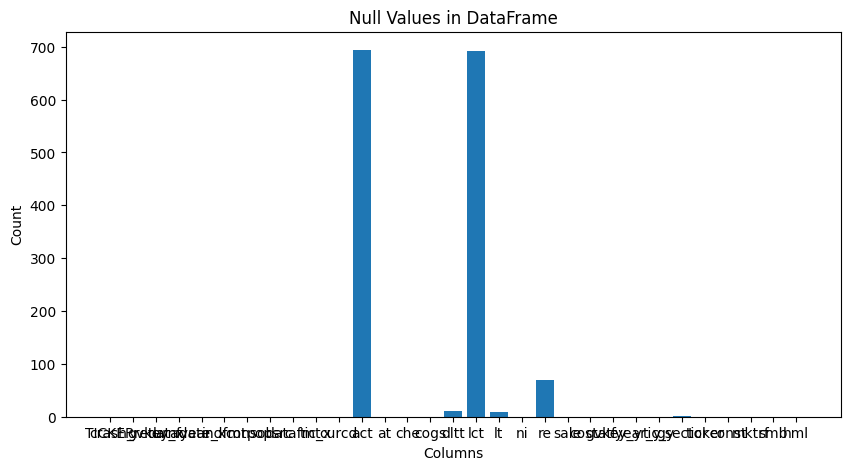

In [346]:
# Calculate the number of null values in each column
null_counts = merged_data.isnull().sum()

# Create a bar chart to visualize the null values
plt.figure(figsize=(10, 5))
plt.bar(null_counts.index, null_counts.values)
plt.title('Null Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [347]:
merged_data.drop(columns=['tic_x', 'tic_y', 'ticker'], inplace=True)

In [348]:
for_reg = pd.get_dummies(merged_data, columns=['gsector'])
for_reg.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'gsector_10.0', 'gsector_15.0',
       'gsector_20.0', 'gsector_25.0', 'gsector_30.0', 'gsector_35.0',
       'gsector_40.0', 'gsector_45.0', 'gsector_50.0', 'gsector_55.0',
       'gsector_60.0'],
      dtype='object')

In [349]:
def ols_missing(for_reg, target):
    for_reg = for_reg.drop(columns=['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
                                     'consol', 'popsrc', 'datafmt', 'curcd', 'costat', 'gvkey_y', 'fyear_y',
                                     'const', 'mktrf', 'smb', 'hml'])

    clean = for_reg.dropna(subset=[target])
    with_null = for_reg[for_reg[target].isnull()]

    col_list = clean.columns
    temp = []
    for i in col_list:
        if i not in ['act', 'lt', 'dltt', 'lct', 're']:
            temp.append(i)

    x = clean[temp]
    y = clean[target]

    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()

    X_missing = sm.add_constant(with_null[temp], has_constant='add')

    temp = model.predict(X_missing)
    with_null.loc[:, target] = temp

    df_filled = pd.concat([clean, with_null]).sort_index()
    return df_filled


In [351]:
pd.options.mode.chained_assignment = None

#impute missing data
temp = ols_missing(for_reg, 'act')
merged_data['act'] = temp['act']
temp = ols_missing(for_reg, 'cogs')
merged_data['cogs'] = temp['cogs']
temp = ols_missing(for_reg, 'dltt')
merged_data['dltt'] = temp['dltt']
temp = ols_missing(for_reg, 'lct')
merged_data['lct'] = temp['lct']
temp = ols_missing(for_reg, 're')
merged_data['re'] = temp['re']

In [352]:
from scipy.stats.mstats import winsorize

#financial ratios
merged_data['debt_to_equity_ratio'] = (merged_data['dltt'] + (merged_data['lt'] - merged_data['lct']))/ (merged_data['at'] - merged_data['lt'])
merged_data['current_ratio'] = merged_data['act'] / merged_data['lct']
merged_data['gross_profit'] = (merged_data['sale'] - merged_data['cogs'])/ merged_data['sale']
merged_data['asset_turnover_ratio'] = merged_data['sale']/merged_data['at']
merged_data['roa'] = merged_data['ni']/merged_data['at']
merged_data['roe'] = merged_data['ni']/(merged_data['at'] - merged_data['lt'])
merged_data['net_profit_margin'] = merged_data['ni']/merged_data['sale']

#winsorize
merged_data['debt_to_equity_ratio'] = winsorize(merged_data['debt_to_equity_ratio'], limits=(0.01, 0.01))
merged_data['current_ratio'] = winsorize(merged_data['current_ratio'], limits=(0.01, 0.01))
merged_data['gross_profit'] = winsorize(merged_data['gross_profit'], limits=(0.01, 0.01))
merged_data['asset_turnover_ratio'] = winsorize(merged_data['asset_turnover_ratio'], limits=(0.01, 0.01))
merged_data['roa'] = winsorize(merged_data['roa'], limits=(0.01, 0.01))
merged_data['roe'] = winsorize(merged_data['roe'], limits=(0.01, 0.01))
merged_data['net_profit_margin'] = winsorize(merged_data['net_profit_margin'], limits=(0.01, 0.01))

In [353]:
#drop null data
merged_data = merged_data[np.isfinite(merged_data['debt_to_equity_ratio']) 
                        & np.isfinite(merged_data['current_ratio']) 
                        & np.isfinite(merged_data['gross_profit'])
                        & np.isfinite(merged_data['asset_turnover_ratio'])
                        & np.isfinite(merged_data['roa'])
                        & np.isfinite(merged_data['roe'])
                        & np.isfinite(merged_data['net_profit_margin'])]

In [354]:
merged_data = pd.get_dummies(merged_data, columns=['gsector'])
merged_data.columns

Index(['TICKER', 'crash_return', 'gvkey_x', 'datadate', 'fyear_x', 'indfmt',
       'consol', 'popsrc', 'datafmt', 'curcd', 'act', 'at', 'che', 'cogs',
       'dltt', 'lct', 'lt', 'ni', 're', 'sale', 'costat', 'gvkey_y', 'fyear_y',
       'const', 'mktrf', 'smb', 'hml', 'debt_to_equity_ratio', 'current_ratio',
       'gross_profit', 'asset_turnover_ratio', 'roa', 'roe',
       'net_profit_margin', 'gsector_10.0', 'gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0'],
      dtype='object')

### 1. Ratio

In [355]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                  'asset_turnover_ratio','roa', 'roe', 'net_profit_margin']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     24.64
Date:                Sat, 06 May 2023   Prob (F-statistic):           7.15e-33
Time:                        07:10:02   Log-Likelihood:                 3553.0
No. Observations:                3026   AIC:                            -7090.
Df Residuals:                    3018   BIC:                            -7042.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0527 

The adjusted R-squared value is 0.052, which is slightly lower than the R-squared value. The model explains approximately 5.2% of the variation in crash_return after adjusting for the number of independent variables.

The significant coefficients in the model are:

const: The coefficient of -0.0527 indicates the expected crash_return when all independent variables are equal to zero.

debt_to_equity_ratio: The coefficient of -0.0002 indicates that for a 1 unit increase in debt_to_equity_ratio, the crash_return is expected to decrease by 0.0002 units.

current_ratio: The coefficient of -0.0012 indicates that for a 1 unit increase in current_ratio, the crash_return is expected to decrease by 0.0012 units.

roa: The coefficient of 0.0868 indicates that for a 1 unit increase in roa, the crash_return is expected to increase by 0.0868 units.

roe: The coefficient of 0.0075 indicates that for a 1 unit increase in roe, the crash_return is expected to increase by 0.0075 units.

### 2. 3-factor risk

In [356]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     262.3
Date:                Sat, 06 May 2023   Prob (F-statistic):          2.75e-151
Time:                        07:10:03   Log-Likelihood:                 3819.1
No. Observations:                3026   AIC:                            -7630.
Df Residuals:                    3022   BIC:                            -7606.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0070      0.003     -2.625      0.0

The adjusted R-squared value is 0.206, which indicates that 20.6% of the variance in the crash_return can be explained by the independent variables in this model. This is relatively high, which means the model fits the data well.

The significant coefficients in the model are:

const: The coefficient of -0.007 indicates the expected crash_return when all independent variables are equal to zero.

mktrf: The coefficient of -0.0491 indicates that for a 1 unit increase in mktrf, the crash_return is expected to decrease by 0.0491 units.

smb: The coefficient of -0.0130 indicates that for a 1 unit increase in smb, the crash_return is expected to decrease by 0.0130 units.

hml: The coefficient of 0.0308 indicates that for a 1 unit increase in hml, the crash_return is expected to increase by 0.0308 units.

###3. Industry categorical

In [357]:
#define the independent variables
X = merged_data[['gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     16.69
Date:                Sat, 06 May 2023   Prob (F-statistic):           9.19e-30
Time:                        07:10:03   Log-Likelihood:                 3550.5
No. Observations:                3026   AIC:                            -7079.
Df Residuals:                    3015   BIC:                            -7013.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0249      0.006     -4.506   

The adjusted R-squared value is 0.049, which is close to the R-squared value. The model explains approximately 4.9% of the variation in crash_return after adjusting for the number of independent variables.

All the industry sector coefficients (gsector_15.0, gsector_20.0, gsector_25.0, gsector_35.0, gsector_40.0, gsector_45.0, gsector_50.0, and gsector_60.0) have p-values less than 0.05, which means that these sectors are significantly related to the crash return. However, gsector_30.0 and gsector_55.0 have p-values greater than 0.05, indicating that these sectors are not significantly related to the crash return.

### 1&2

In [358]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'mktrf', 'smb', 'hml']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     88.07
Date:                Sat, 06 May 2023   Prob (F-statistic):          9.56e-160
Time:                        07:10:04   Log-Likelihood:                 3856.7
No. Observations:                3026   AIC:                            -7691.
Df Residuals:                    3015   BIC:                            -7625.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0137 

The adjusted R-squared value is 0.223. The model explains approximately 22.3% of the variation in crash_return after adjusting for the number of independent variables.

The significant coefficients are those with a p-value less than 0.05. These include:

const: with a t-statistic of -4.354 and a p-value of 0.000, this constant term is significant. It represents the intercept of the model, the expected crash return when all other independent variables are zero.

gross_profit: with a t-statistic of -2.071 and a p-value of 0.038, this variable is significant. It suggests that an increase in the gross profit of the company is associated with a decrease in the crash return.

current_ratio: with a t-statistic of 2.225 and a p-value of 0.026, this variable is significant. It suggests that an increase in the current ratio of the company is associated with an increase in the crash return.

asset_turnover_ratio: with a t-statistic of 2.442 and a p-value of 0.015, this variable is significant. It suggests that an increase in the asset turnover ratio of the company is associated with an increase in the crash return.

roa: with a t-statistic of 4.843 and a p-value of 0.000, this variable is significant. It suggests that an increase in the return on assets of the company is associated with an increase in the crash return.

roe: with a t-statistic of 2.649 and a p-value of 0.008, this variable is significant. It suggests that an increase in the return on equity of the company is associated with an increase in the crash return.

mktrf: with a t-statistic of -22.128 and a p-value of 0.000, this variable is significant. It represents the market risk factor and suggests that an increase in the market risk factor is associated with a decrease in the crash return.

smb: with a t-statistic of -12.596 and a p-value of 0.000, this variable is significant. It represents the small minus big factor and suggests that an increase in the small minus big factor is associated with a decrease in the crash return.

hml: with a t-statistic of 15.402 and a p-value of 0.000, this variable is significant. It represents the high minus low factor and suggests that an increase in the high minus low factor is associated with an increase in the crash return.

### 2&3

In [359]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml','gsector_15.0', 'gsector_20.0',
       'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
       'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     67.96
Date:                Sat, 06 May 2023   Prob (F-statistic):          1.79e-157
Time:                        07:10:05   Log-Likelihood:                 3858.1
No. Observations:                3026   AIC:                            -7688.
Df Residuals:                    3012   BIC:                            -7604.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0222      0.006      3.491   

The adjusted R-squared value is 0.223, which is close to the R-squared value. The model explains approximately 22.3% of the variation in crash_return after adjusting for the number of independent variables.

The significant coefficients (with a p-value of less than 0.05) are:

const: the constant term in the model, which represents the expected crash_return when all the independent variables are equal to zero. This coefficient is significant and has a negative value, meaning that the expected crash_return is lower than zero.

mktrf: The coefficient for the "mktrf" variable is significant and has a negative value, indicating that an increase in the market risk factor is associated with a decrease in crash_return.

smb: The coefficient for the "smb" variable is significant and has a negative value, indicating that an increase in the small-minus-big factor is associated with a decrease in crash_return.

hml: The coefficient for the "hml" variable is significant and has a positive value, indicating that an increase in the high-minus-low factor is associated with an increase in crash_return.

gsector_15.0 to gsector_60.0: The coefficients for the categorical industry variables are significant and have negative values, indicating that being in certain industries (gsector_15.0, gsector_20.0, gsector_25.0, gsector_35.0, gsector_40.0, gsector_45.0, gsector_50.0, and gsector_60.0) is associated with a decrease in crash_return.

### 1&3

In [360]:
#define the independent variables
X = merged_data[['debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     18.52
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.01e-53
Time:                        07:10:05   Log-Likelihood:                 3619.6
No. Observations:                3026   AIC:                            -7203.
Df Residuals:                    3008   BIC:                            -7095.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0271 

The adjusted R-squared value is 0.090, which is close to the R-squared value. The model explains approximately 9.0% of the variation in crash_return after adjusting for the number of independent variables.

In this model, the following coefficients are significant:

mktrf: -0.0501, with a p-value of 0.000, indicating a negative relationship between the market risk factor and crash return.

smb: -0.0138, with a p-value of 0.000, indicating a negative relationship between the small minus big factor and crash return.

hml: 0.0291, with a p-value of 0.000, indicating a positive relationship between the high minus low factor and crash return.

gsector_15.0 to gsector_60.0: The coefficients for each of the sector dummy variables are significant, with p-values less than 0.05, indicating a relationship between each sector and crash return.

### 1&2&3

In [361]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml',
                 'debt_to_equity_ratio', 'gross_profit', 'current_ratio',
                 'asset_turnover_ratio','roa', 'roe', 'net_profit_margin',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_30.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_55.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     48.62
Date:                Sat, 06 May 2023   Prob (F-statistic):          4.18e-166
Time:                        07:10:06   Log-Likelihood:                 3893.1
No. Observations:                3026   AIC:                            -7744.
Df Residuals:                    3005   BIC:                            -7618.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0147 

The adjusted R-squared value is 0.239. The model explains approximately 23.9% of the variation in crash_return after adjusting for the number of independent variables.

In this model, the following coefficients are significant:

const: Constant term with a significant positive coefficient of 0.0147. This means that the average return for the dependent variable is positive, even if all other independent variables are equal to zero.

mktrf: Market return factor with a significant negative coefficient of -0.0491. This means that a unit increase in the market return factor is associated with a decrease in the dependent variable's return by 0.0491 units.

smb: Small minus big factor with a significant negative coefficient of -0.0124. This means that a unit increase in the small minus big factor is associated with a decrease in the dependent variable's return by 0.0124 units.

hml: High minus low factor with a significant positive coefficient of 0.0281. This means that a unit increase in the high minus low factor is associated with an increase in the dependent variable's return by 0.0281 units.

gsector_15.0 to gsector_60.0: Industry sector dummies with significant coefficients ranging from -0.0508 to -0.0426. This means that the returns for different industry sectors are different from each other and a unit change in one of the dummies is associated with a change in the dependent variable's return by the corresponding coefficient value.

### Final regression

In [363]:
#define the independent variables
X = merged_data[['mktrf', 'smb', 'hml',
                 'gross_profit', 'roa', 'roe',
                 'gsector_15.0', 'gsector_20.0',
                 'gsector_25.0', 'gsector_35.0', 'gsector_40.0',
                 'gsector_45.0', 'gsector_50.0', 'gsector_60.0']]
X = sm.add_constant(X)

#define the dependent variable
y = merged_data['crash_return']

#fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           crash_return   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     68.94
Date:                Sat, 06 May 2023   Prob (F-statistic):          5.47e-170
Time:                        07:26:23   Log-Likelihood:                 3889.6
No. Observations:                3026   AIC:                            -7749.
Df Residuals:                    3011   BIC:                            -7659.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0098      0.004      2.364   

The most important variables for 2000 crash is mktrf, smb, hml,
gross_profit, roa, roe,
gsector_15.0, gsector_20.0,
gsector_25.0, gsector_35.0, gsector_40.0, gsector_45.0, gsector_50.0, gsector_60.0 because all of them are statiscally significance.